<a href="https://colab.research.google.com/github/yrodriguezmd/Deep_Learning_tutorials/blob/main/02_Models_frcnn_ret_vf1x%2C2x_yolo5%2CX_Surg_nov14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use new annotated set 'Second_set' of Surgical Instruments.

Compare 5 models: faster rcnn, retinanet, vfnet, yolov5, yolox.

Sub-study: compare 2 backbones of vfnet: resnet50_fpn_mstrain_2x and resnet50_fpn_1x.


In [ ]:
# Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# Choose your installation target: cuda11 or cuda10 or cpu
!bash icevision_install.sh cuda11 master

In [2]:
# Restart kernel after installation
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'restart': True, 'status': 'ok'}

In [ ]:
#import icevision

In [ ]:
from icevision.all import *

In [ ]:
#print('icevision v',icevision.__version__)
#print('torch v',torch.__version__)
#print('torchvision v',torchvision.__version__)
#print('torchtext',torchtext.__version__)

icevision v 0.11.0
torch v 1.10.0+cu111
torchvision v 0.11.1+cu111


In [ ]:
# contains labelled data
#!git clone https://github.com/yrodriguezmd/Surgical_instruments.git

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [ ]:
#!ls Surgical_instruments/Sets/Set_S/subsets/Set_1_7

In [ ]:
!ls gdrive/MyDrive/Surgical_instruments/Second_set.v1i.coco  ##
# 'Second_set' with 1714 train, 474 valid and 21 test items

README.dataset.txt  README.roboflow.txt  test  train  valid


Preparation

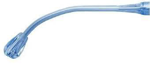

In [3]:
image_path = Path('gdrive/MyDrive/Surgical_instruments/Second_set.v1i.coco/train')

img_files = get_image_files(image_path)

img = PIL.Image.open(img_files[1501]) ##
img = img.convert('RGB')

img.to_thumb(150,150)

In [4]:
classes = ['Army_navy', 'Bulldog', 'Castroviejo','Forceps', 'Frazier', 'Hemostat','Iris','Mayo_metz','Needle','Potts','Richardson','Scalpel','Towel_clip', 'Weitlaner','Yankauer']
class_map = ClassMap(classes)
len(class_map)

16

Parse data

In [5]:
path = Path('gdrive/MyDrive/Surgical_instruments/Second_set.v1i.coco')

train_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'train/_annotations.coco.json',## mayo-metz removed in vscode
    img_dir = path/'train'
)

valid_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'valid/_annotations.coco.json',##
    img_dir = path/'valid'
)

In [ ]:
# dataset already split in annotation tool, maintain grouping
whole = SingleSplitSplitter()

train_records, *_ = train_parser.parse(data_splitter = whole)

valid_records, *_ = valid_parser.parse(data_splitter = whole)

In [7]:
len(train_parser.class_map)

16

In [8]:
train_parser.class_map

<ClassMap: {'background': 0, 'Army_navy': 1, 'Bulldog': 2, 'Castroviejo': 3, 'Forceps': 4, 'Frazier': 5, 'Hemostat': 6, 'Iris': 7, 'Mayo_metz': 8, 'Needle': 9, 'Potts': 10, 'Richardson': 11, 'Scalpel': 12, 'Towel_clip': 13, 'Weitlaner': 14, 'Yankauer': 15}>

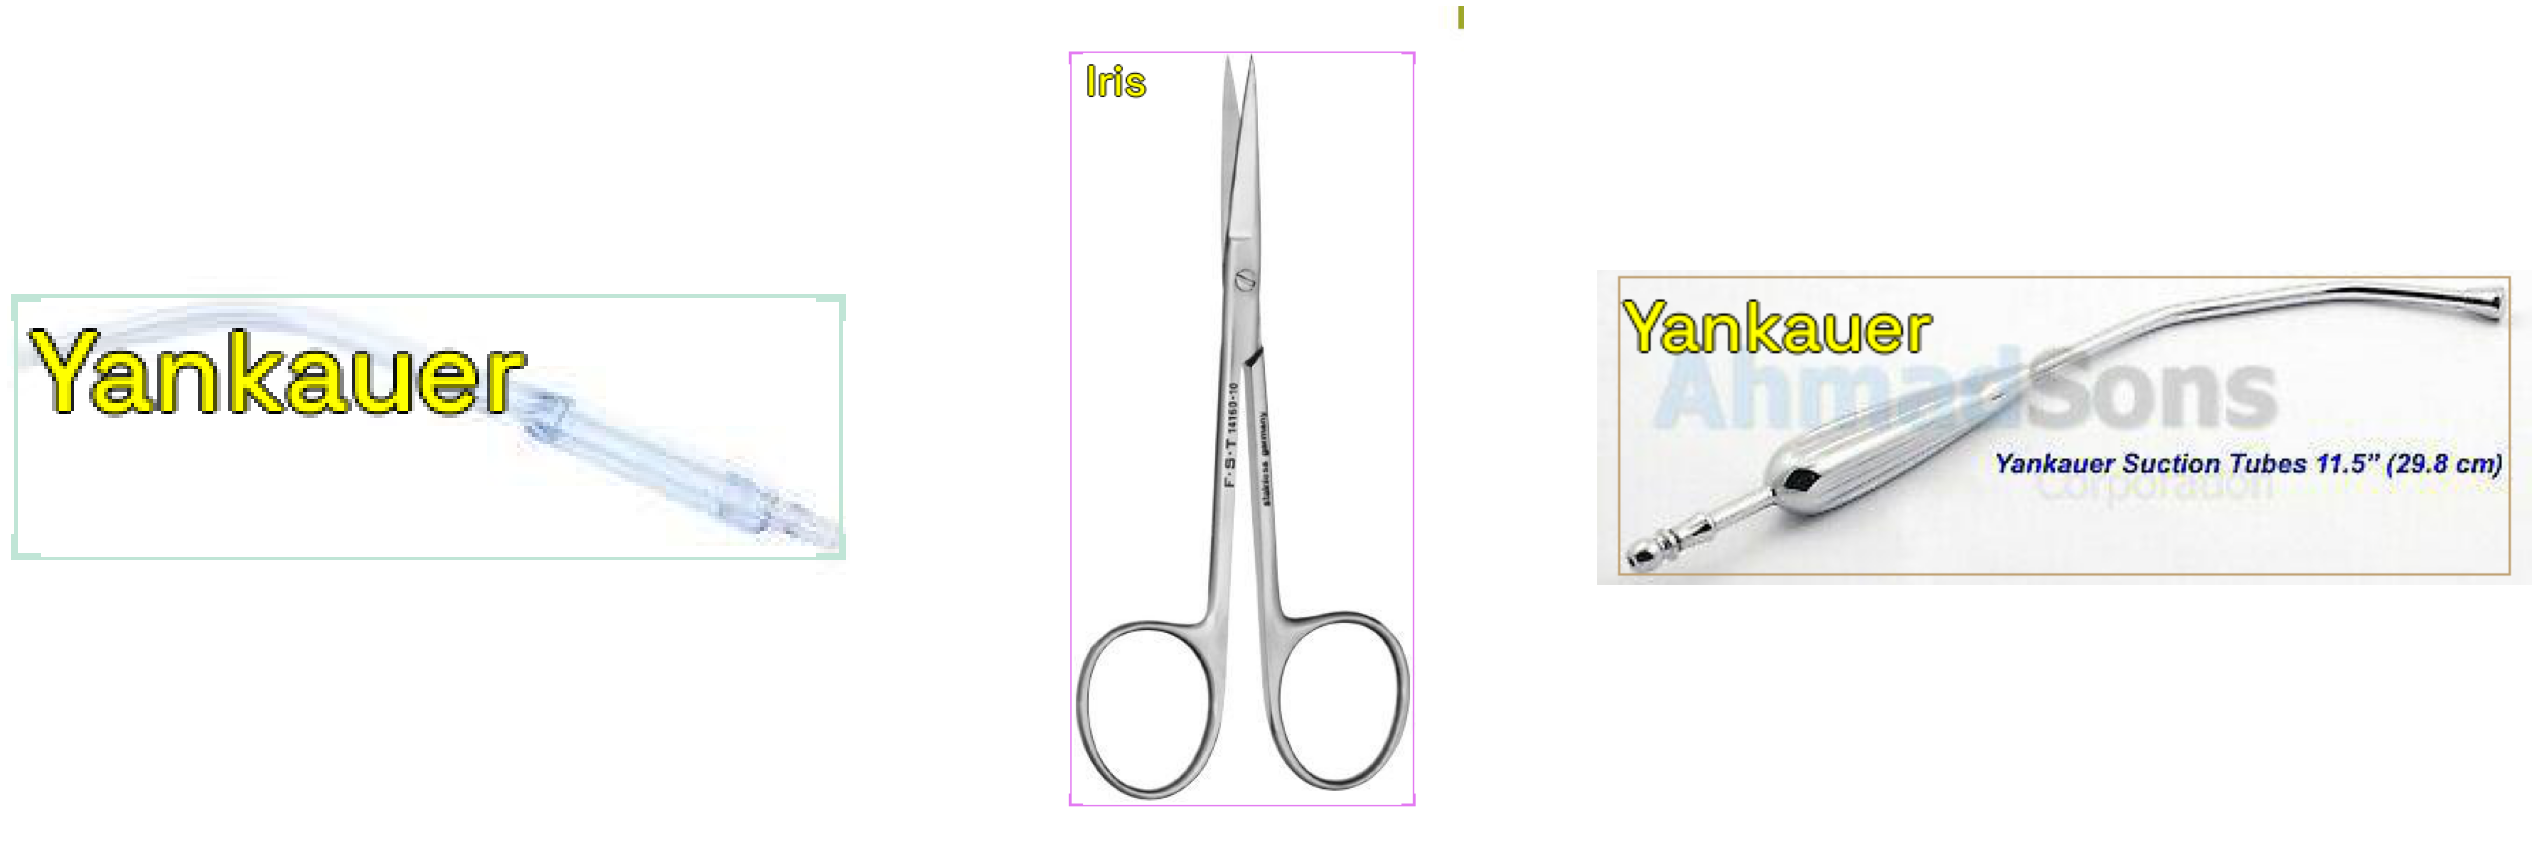

In [ ]:
show_records(train_records[0:3],ncols=3, font_size=30, label_color = '#ffff00')

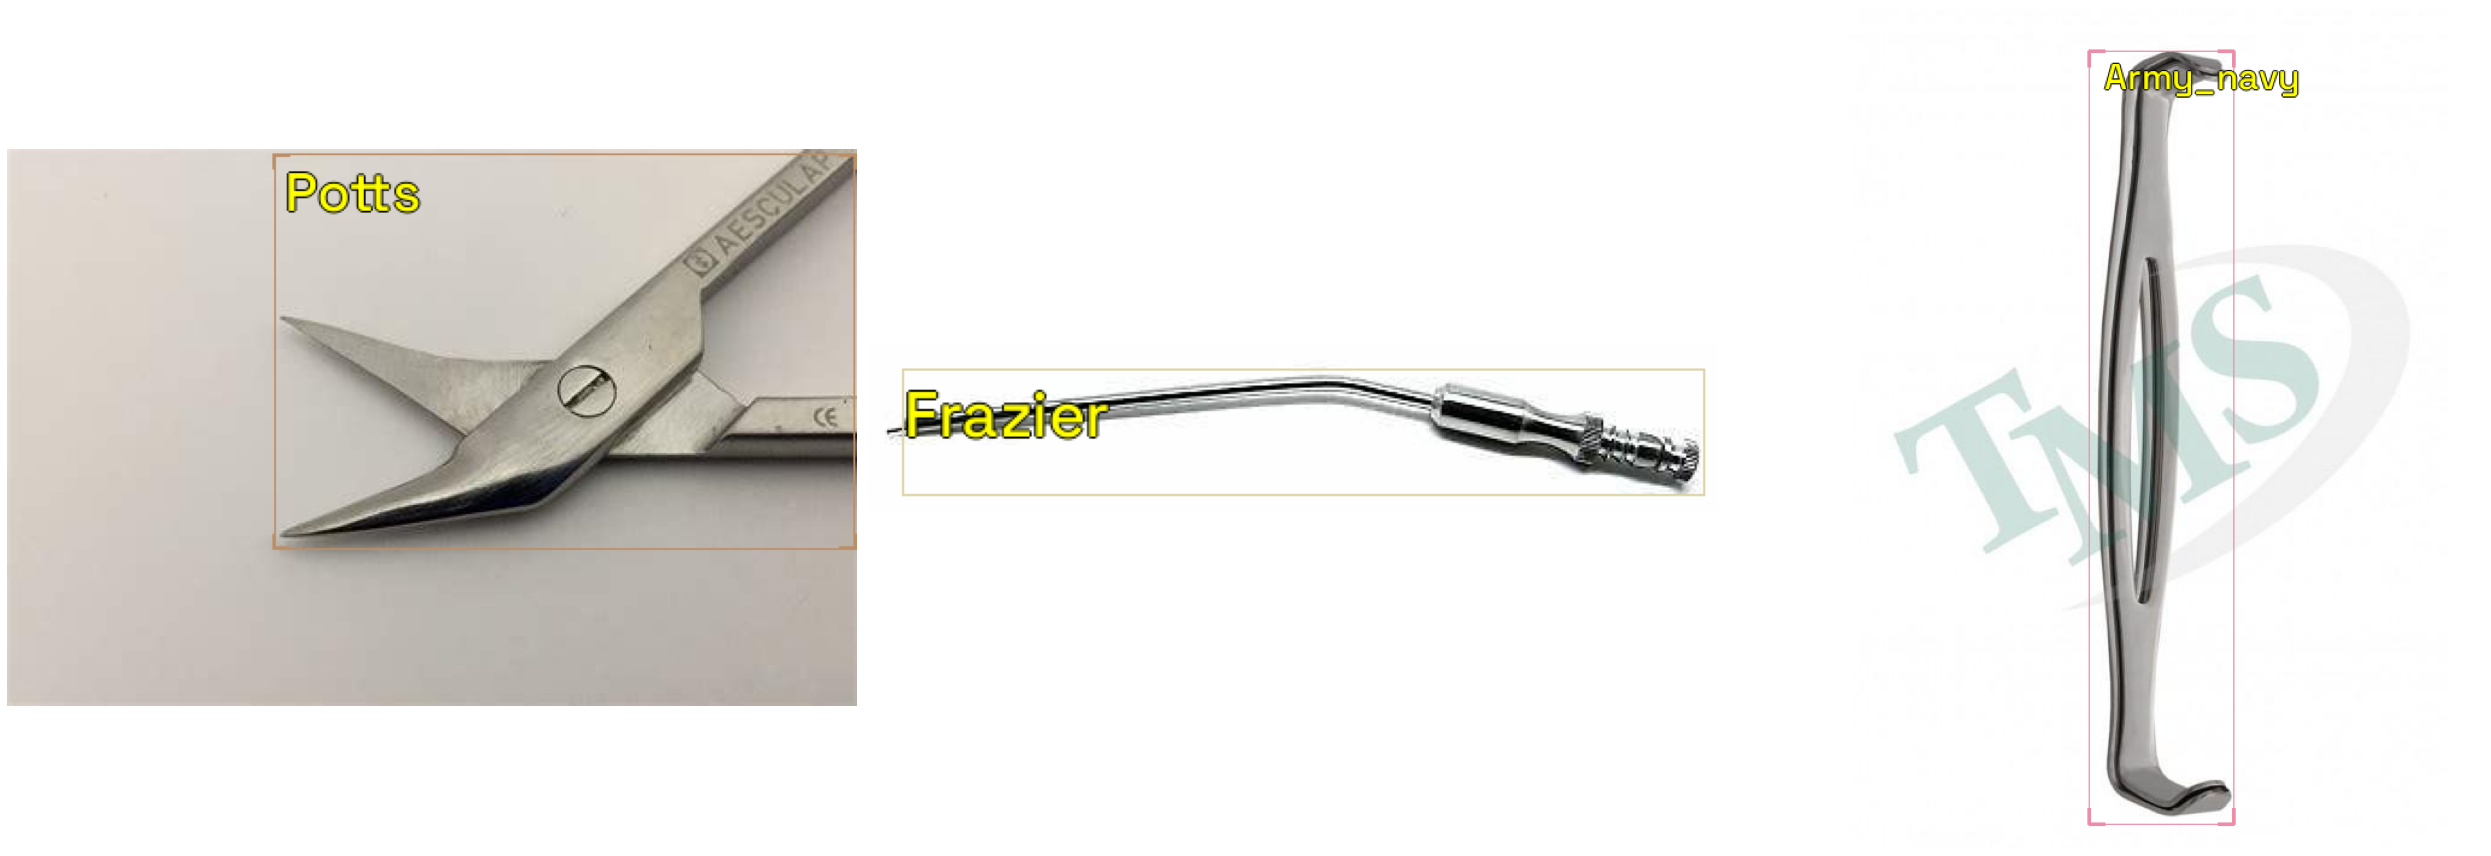

In [ ]:
show_records(valid_records[0:3],ncols=3, font_size=30, label_color = '#ffff00')

In [9]:
presize = 512 #
image_size = 384 #

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=image_size), tfms.A.Normalize()])

In [10]:
train_ds = Dataset(train_records, train_tfms) ## 
valid_ds = Dataset(valid_records, valid_tfms)

In [11]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [12]:
from icevision.models.checkpoint import *

In [13]:
from fastai.callback.wandb import *
from fastai.callback.tracker import SaveModelCallback

Faster_RCNN

In [ ]:
model_type_frcnn = models.torchvision.faster_rcnn ##
model_frcnn = model_type_frcnn.model( ##
                      num_classes=len(class_map))
train_dl_frcnn = model_type_frcnn.train_dl(train_ds, ##
                      batch_size=16, num_workers=4, shuffle=True)
valid_dl_frcnn = model_type_frcnn.valid_dl(valid_ds, ##
                      batch_size=16, num_workers=4, shuffle=False)

In [ ]:
wandb.init(project = 'Surgical_instruments_models_', name = 'Faster_RCNN', ##
           reinit = True)

In [ ]:
learn_frcnn = model_type_frcnn.fastai.learner(dls = [train_dl_frcnn, valid_dl_frcnn],##
                                  model = model_frcnn, ##
                                   metrics = metrics, 
                                  cbs = [WandbCallback(),#
                                  SaveModelCallback()]) #

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


SuggestedLRs(valley=0.00015848931798245758)

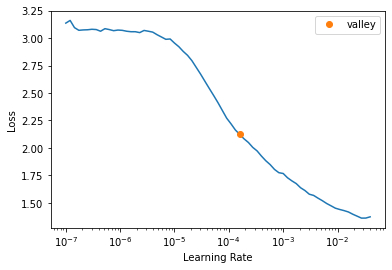

In [ ]:
learn_frcnn.lr_find()

In [ ]:
learn_frcnn.fine_tune(100, 2e-04)

Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'Dataset' object has no attribute 'items'


Better model found at epoch 0 with valid_loss value: 0.28925567865371704.
Could not gather input dimensions


Better model found at epoch 0 with valid_loss value: 0.23677784204483032.
Better model found at epoch 1 with valid_loss value: 0.21134434640407562.
Better model found at epoch 2 with valid_loss value: 0.19572727382183075.
Better model found at epoch 3 with valid_loss value: 0.1847175657749176.
Better model found at epoch 4 with valid_loss value: 0.17569543421268463.
Better model found at epoch 5 with valid_loss value: 0.169162318110466.
Better model found at epoch 6 with valid_loss value: 0.15720011293888092.
Better model found at epoch 7 with valid_loss value: 0.15475575625896454.
Better model found at epoch 9 with valid_loss value: 0.14919112622737885.
Better model found at epoch 10 with valid_loss value: 0.14252014458179474.
Better model found at epoch 12 with valid_loss value: 0.14060911536216736.
Better model found at epoch 14 with valid_loss value: 0.13573569059371948.
Better model found at epoch 15 with valid_loss value: 0.12867416441440582.
Better model found at epoch 20 with v

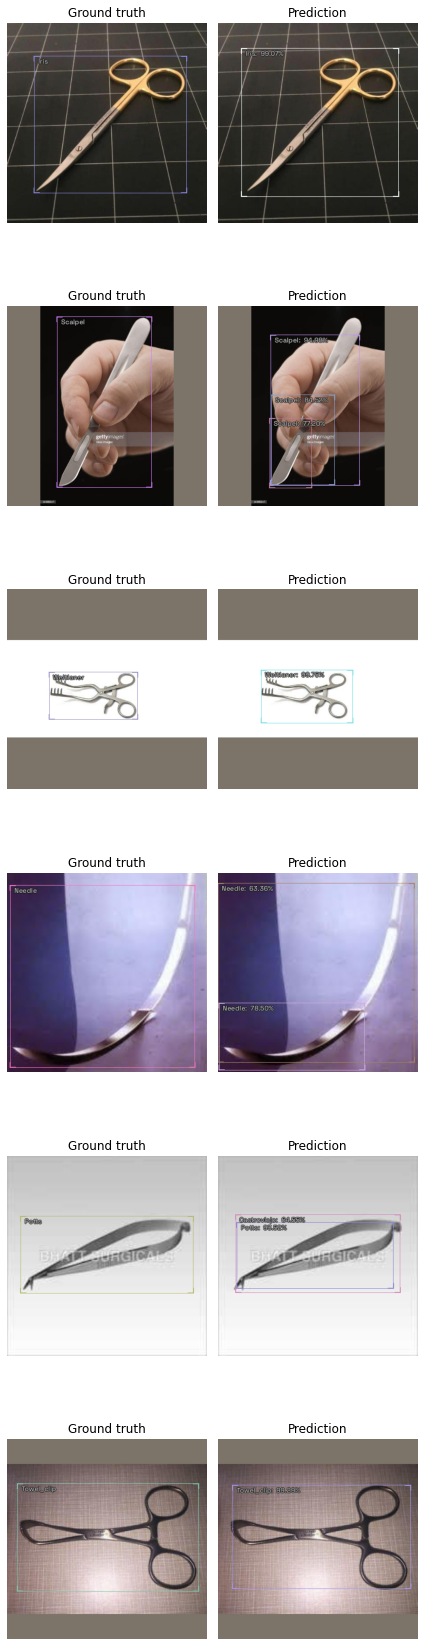

In [ ]:
model_type_frcnn.show_results(model_frcnn,##
                              valid_ds)

In [ ]:
root_dir = Path('/content/gdrive/My Drive/')

from icevision.models import *

checkpoint_path = root_dir/'Surgical_instruments/Models/FasterRCNN_nov13_mAP68.5.pth' #100 epochs, vf

save_icevision_checkpoint(model_frcnn,## 
                        model_name='torchvision.faster_rcnn', ## 
                        #backbone_name='resnet50_fpn_mstrain_2x', ##
                        classes =  train_parser.class_map.get_classes(), 
                        img_size=image_size, 
                        filename=str(checkpoint_path), ##
                        meta={'icevision_version': '0.9.1'})

RetinaNet

In [ ]:
model_type_ret = models.mmdet.retinanet #
backbone_r50 = model_type_ret.backbones.resnet50_fpn_1x(pretrained=True)#
model_ret = model_type_ret.model(backbone=backbone_r50(pretrained=True), #
                      num_classes=len(class_map))

train_dl_ret = model_type_ret.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)#
valid_dl_ret = model_type_ret.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)#

In [ ]:
wandb.init(project = 'Surgical_instruments_models_', name = 'RetinaNet', ##
           reinit = True)

In [ ]:
learn_ret = model_type_ret.fastai.learner(dls = [train_dl_ret, valid_dl_ret],##
                                  model = model_ret, ##
                                   metrics = metrics, 
                                  cbs = [WandbCallback(),#
                                  SaveModelCallback()]) #

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=5.248074739938602e-05)

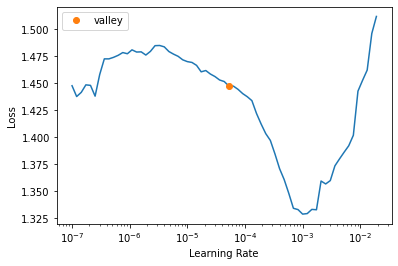

In [ ]:
learn_ret.lr_find()#

In [ ]:
learn_ret.fine_tune(100, 5e-05, freeze_epochs=1) #ret

Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'Dataset' object has no attribute 'items'


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


Better model found at epoch 0 with valid_loss value: 0.7651546001434326.
Could not gather input dimensions


Better model found at epoch 0 with valid_loss value: 0.6743220090866089.
Better model found at epoch 1 with valid_loss value: 0.6492215991020203.
Better model found at epoch 2 with valid_loss value: 0.6277543306350708.
Better model found at epoch 3 with valid_loss value: 0.6060283184051514.
Better model found at epoch 4 with valid_loss value: 0.5996994376182556.
Better model found at epoch 5 with valid_loss value: 0.577287495136261.
Better model found at epoch 6 with valid_loss value: 0.5593642592430115.
Better model found at epoch 7 with valid_loss value: 0.5521188378334045.
Better model found at epoch 8 with valid_loss value: 0.5383971333503723.
Better model found at epoch 9 with valid_loss value: 0.5053008198738098.
Better model found at epoch 10 with valid_loss value: 0.5002903342247009.
Better model found at epoch 11 with valid_loss value: 0.4935972988605499.
Better model found at epoch 12 with valid_loss value: 0.4786856472492218.
Better model found at epoch 13 with valid_loss va

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


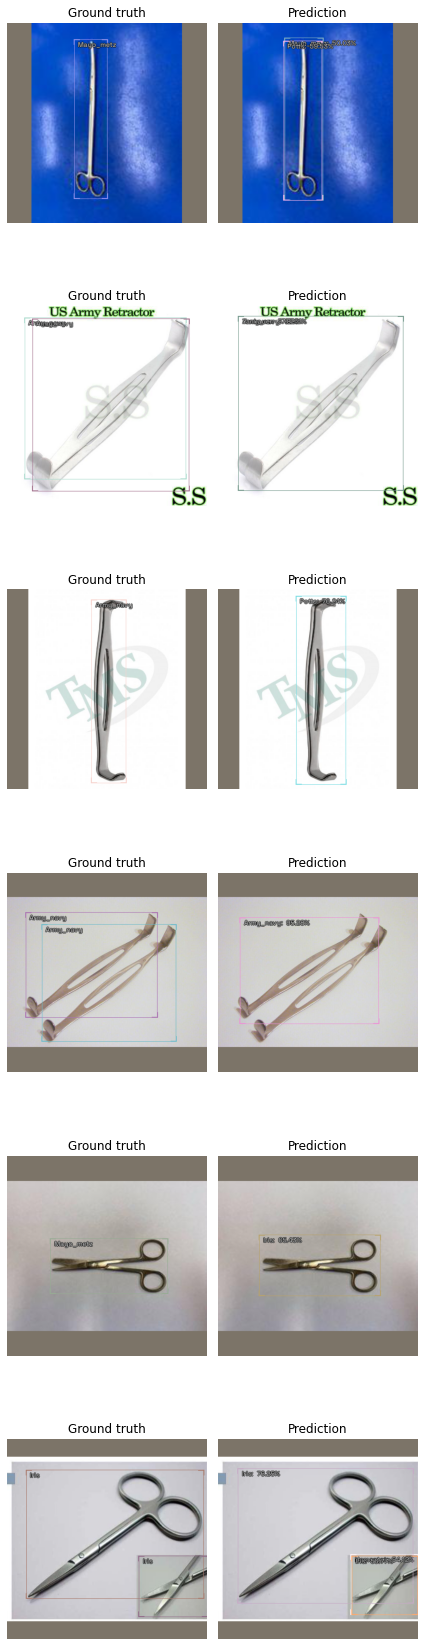

In [ ]:
model_type_ret.show_results(model_ret,##
                              valid_ds)

In [ ]:
#root_dir = Path('/content/gdrive/My Drive/')

#from icevision.models import *

checkpoint_path = root_dir/'Surgical_instruments/Models/RetinaNet_nov13_mAP64.1.pth' #100 epochs, vf

save_icevision_checkpoint(model_frcnn,## 
                        model_name='mmdet.retinanet', ## 
                        backbone_name='resnet50_fpn_1x', ##
                        classes =  train_parser.class_map.get_classes(), 
                        img_size=image_size, 
                        filename=str(checkpoint_path), ##
                        meta={'icevision_version': '0.9.1'})

VFNet

In [ ]:
model_type_vf = models.mmdet.vfnet #
backbone_vf_r50 = model_type_vf.backbones.resnet50_fpn_mstrain_2x(pretrained=True)#
model_vf = model_type_vf.model(backbone=backbone_vf_r50(pretrained=True), #
                      num_classes=len(class_map))

train_dl_vf = model_type_vf.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)#
valid_dl_vf = model_type_vf.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)#

In [ ]:
wandb.init(project = 'Surgical_instruments_models_', name = 'VFNet', ##
           reinit = True)

In [ ]:
learn_vf = model_type_vf.fastai.learner(dls = [train_dl_vf, valid_dl_vf],##
                                  model = model_vf, ##
                                   metrics = metrics, 
                                  cbs = [WandbCallback(),#
                                  SaveModelCallback()]) #

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=0.010964781977236271)

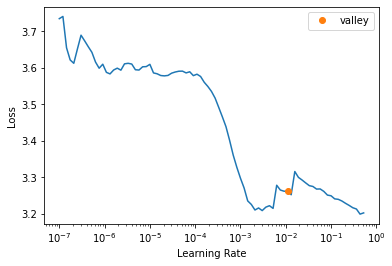

In [ ]:
learn_vf.lr_find()#

In [ ]:
learn_vf.fine_tune(100, 5e-04, freeze_epochs=1) #

Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'Dataset' object has no attribute 'items'


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


Better model found at epoch 0 with valid_loss value: 2.0637946128845215.
Could not gather input dimensions


Better model found at epoch 0 with valid_loss value: 1.6743043661117554.
Better model found at epoch 1 with valid_loss value: 1.5603272914886475.
Better model found at epoch 2 with valid_loss value: 1.475510835647583.
Better model found at epoch 3 with valid_loss value: 1.410454273223877.
Better model found at epoch 4 with valid_loss value: 1.3661777973175049.
Better model found at epoch 5 with valid_loss value: 1.2945914268493652.
Better model found at epoch 6 with valid_loss value: 1.275694489479065.
Better model found at epoch 10 with valid_loss value: 1.2176330089569092.
Better model found at epoch 11 with valid_loss value: 1.2113049030303955.
Better model found at epoch 12 with valid_loss value: 1.2067592144012451.
Better model found at epoch 16 with valid_loss value: 1.190639615058899.
Better model found at epoch 17 with valid_loss value: 1.1671042442321777.
Better model found at epoch 26 with valid_loss value: 1.1174993515014648.
Better model found at epoch 30 with valid_loss va

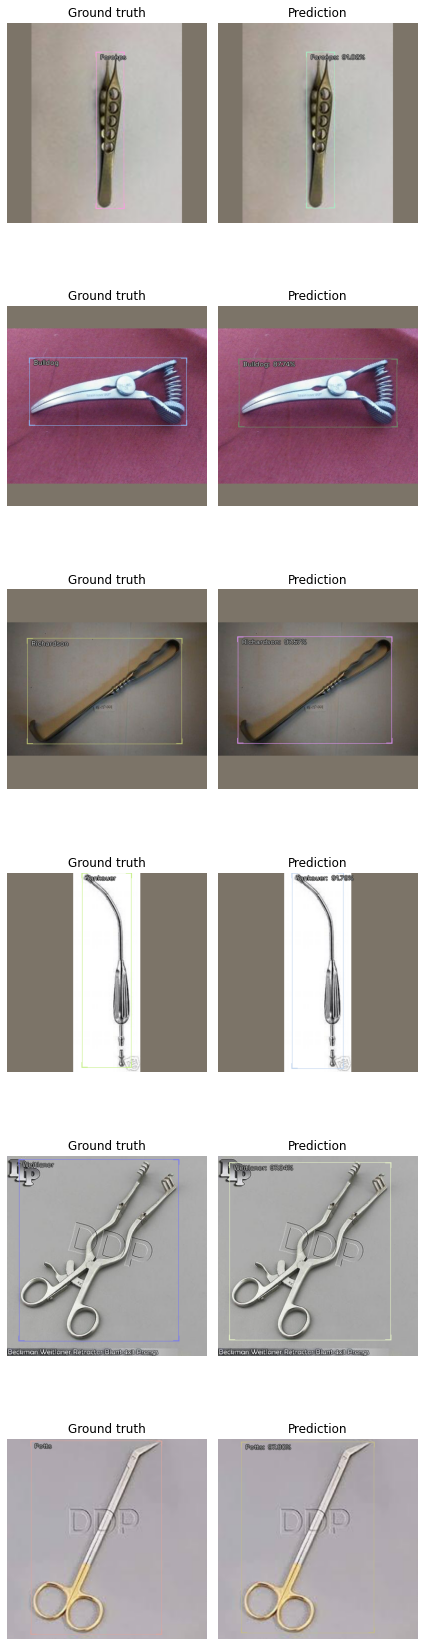

In [ ]:
model_type_vf.show_results(model_vf,##
                              valid_ds)

In [ ]:
 #root_dir = Path('/content/gdrive/My Drive/')

#from icevision.models import *

checkpoint_path = root_dir/'Surgical_instruments/Models/VFNet_nov13_mAP81.5.pth' #100 epochs, vf

save_icevision_checkpoint(model_frcnn,## 
                        model_name='mmdet.vfnet', ## 
                        backbone_name='resnet50_fpn_mstrain_2x', ##
                        classes =  train_parser.class_map.get_classes(), 
                        img_size=image_size, 
                        filename=str(checkpoint_path), ##
                        meta={'icevision_version': '0.9.1'})

YOLOv5

In [ ]:
model_type_yolo5 = models.ultralytics.yolov5 ##
backbone_yolo5 = model_type_yolo5.backbones.small #
model_yolo5 = model_type_yolo5.model(backbone = backbone_yolo5(pretrained=True), ###
                      num_classes=16,## len(class_map),
                      img_size = image_size)#
train_dl_yolo5 = model_type_yolo5.train_dl(train_ds, ##
                      batch_size=16, num_workers=4, shuffle=True)
valid_dl_yolo5 = model_type_yolo5.valid_dl(valid_ds, ##
                      batch_size=16, num_workers=4, shuffle=False)

In [ ]:
wandb.init(project = 'Surgical_instruments_models_', name = 'YOLOv5', ##
           reinit = True)

In [ ]:
learn_yolo5 = model_type_yolo5.fastai.learner(dls = [train_dl_yolo5, valid_dl_yolo5],##
                                  model = model_yolo5, ##
                                   metrics = metrics, 
                                  cbs = [WandbCallback(),#
                                  SaveModelCallback()]) #

SuggestedLRs(valley=0.004365158267319202)

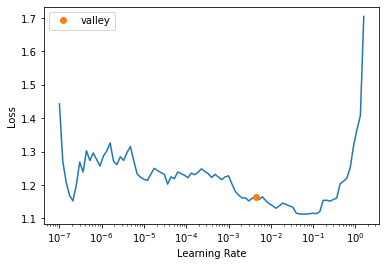

In [ ]:
learn_yolo5.lr_find()#

In [ ]:
learn_yolo5.fine_tune(100, 2e-03, freeze_epochs=1) #

Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'Dataset' object has no attribute 'items'


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Better model found at epoch 0 with valid_loss value: 0.7383451461791992.
Could not gather input dimensions


Better model found at epoch 0 with valid_loss value: 0.6477885246276855.
Better model found at epoch 1 with valid_loss value: 0.5940839648246765.
Better model found at epoch 2 with valid_loss value: 0.5598540902137756.
Better model found at epoch 3 with valid_loss value: 0.5305444002151489.
Better model found at epoch 5 with valid_loss value: 0.510354220867157.
Better model found at epoch 7 with valid_loss value: 0.48745566606521606.
Better model found at epoch 9 with valid_loss value: 0.4802422523498535.
Better model found at epoch 10 with valid_loss value: 0.4576295018196106.
Better model found at epoch 13 with valid_loss value: 0.44504544138908386.
Better model found at epoch 14 with valid_loss value: 0.44085898995399475.
Better model found at epoch 16 with valid_loss value: 0.42605650424957275.
Better model found at epoch 19 with valid_loss value: 0.4179501533508301.
Better model found at epoch 22 with valid_loss value: 0.4037701487541199.
Better model found at epoch 28 with valid_

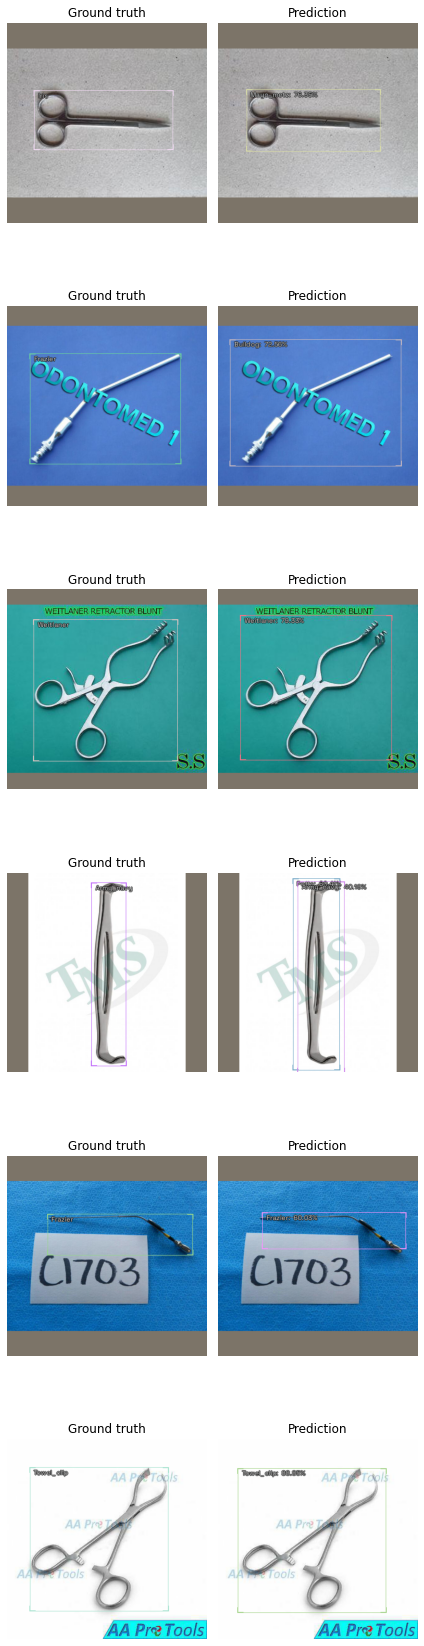

In [ ]:
model_type_yolo5.show_results(model_yolo5,##
                              valid_ds)

In [ ]:
root_dir = Path('/content/gdrive/My Drive/')

from icevision.models import *

checkpoint_path = root_dir/'Surgical_instruments/Models/YOLOv5_nov14_mAP66.6.pth' #100 epochs, vf

save_icevision_checkpoint(model_yolo5,## 
                        model_name='ultralytics.yolov5', ## 
                        backbone_name='small', ##
                        classes =  train_parser.class_map.get_classes(), 
                        img_size=image_size, 
                        filename=str(checkpoint_path), 
                        meta={'icevision_version': '0.9.1'})

VFNet fpn 1x backbone

In [ ]:
model_type_vf_1x = models.mmdet.vfnet #
backbone_vf_r50_1x = model_type_vf_1x.backbones.resnet50_fpn_1x(pretrained=True)#
model_vf_1x = model_type_vf_1x.model(backbone=backbone_vf_r50_1x(pretrained=True), #
                      num_classes=len(class_map))

train_dl_vf_1x = model_type_vf_1x.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)#
valid_dl_vf_1x = model_type_vf_1x.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)#

In [ ]:
wandb.init(project = 'Surgical_instruments_models_', name = 'VFNet_1x', ##
           reinit = True)

In [16]:
learn_vf_1x = model_type_vf_1x.fastai.learner(dls = [train_dl_vf_1x, valid_dl_vf_1x],##
                                  model = model_vf_1x, ##
                                   metrics = metrics, 
                                  cbs = [WandbCallback(),#
                                  SaveModelCallback()]) #

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=0.001737800776027143)

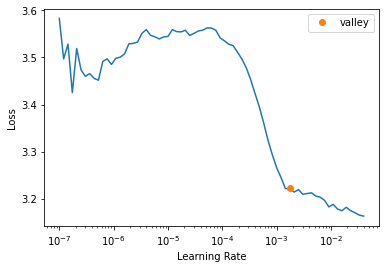

In [17]:
learn_vf_1x.lr_find()#

In [18]:
learn_vf_1x.fine_tune(100, 2e-03)

Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'Dataset' object has no attribute 'items'


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


Better model found at epoch 0 with valid_loss value: 2.2528491020202637.
Could not gather input dimensions


Better model found at epoch 0 with valid_loss value: 1.8183268308639526.
Better model found at epoch 1 with valid_loss value: 1.7382811307907104.
Better model found at epoch 2 with valid_loss value: 1.6681039333343506.
Better model found at epoch 3 with valid_loss value: 1.5784488916397095.
Better model found at epoch 4 with valid_loss value: 1.5736371278762817.
Better model found at epoch 5 with valid_loss value: 1.5097650289535522.
Better model found at epoch 6 with valid_loss value: 1.507570505142212.
Better model found at epoch 7 with valid_loss value: 1.4336885213851929.
Better model found at epoch 8 with valid_loss value: 1.3796966075897217.
Better model found at epoch 9 with valid_loss value: 1.3765143156051636.
Better model found at epoch 22 with valid_loss value: 1.3354758024215698.
Better model found at epoch 27 with valid_loss value: 1.2615000009536743.
Better model found at epoch 29 with valid_loss value: 1.248396635055542.
Better model found at epoch 33 with valid_loss val

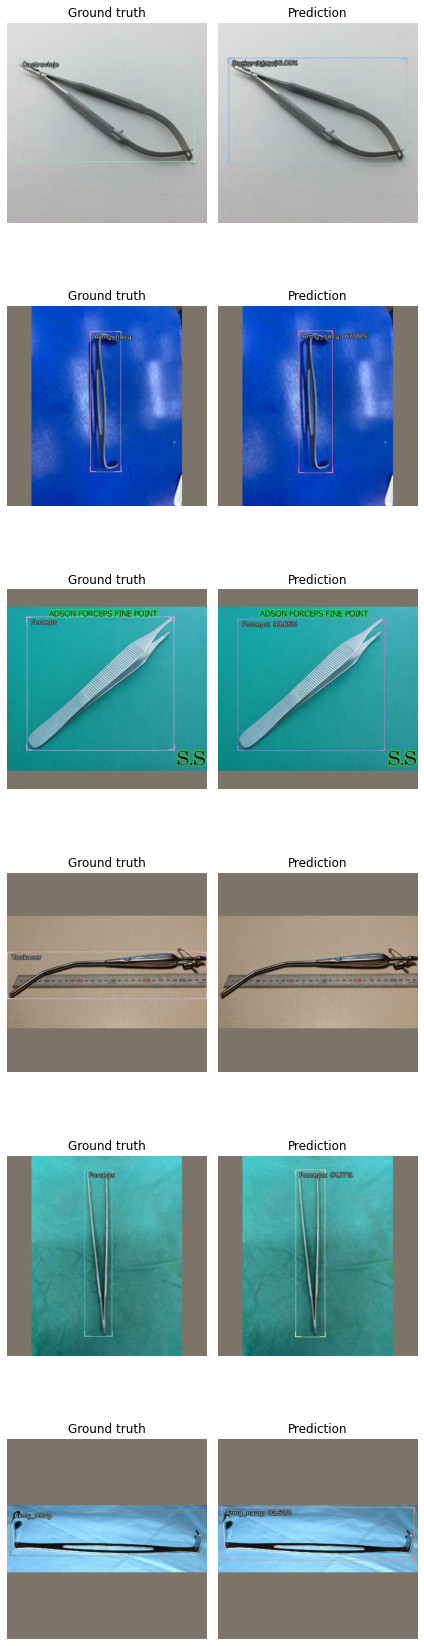

In [ ]:
model_type_vf_1x.show_results(model_vf_1x,##
                              valid_ds)

In [21]:
root_dir = Path('/content/gdrive/My Drive/')

from icevision.models import *

checkpoint_path = root_dir/'Surgical_instruments/Models/VFNet_1x_nov14_mAP79.9.pth' #100 epochs, vf

save_icevision_checkpoint(model_vf_1x,## 
                        model_name='mmdet.vnet', ## 
                        backbone_name='resnet50_fpn_1x', ##
                        classes =  train_parser.class_map.get_classes(), 
                        img_size=image_size, 
                        filename=str(checkpoint_path), 
                        meta={'icevision_version': '0.9.1'})

YOLOX

In [ ]:
model_type_yolox = models.mmdet.yolox ##
backbone_yolox = model_type_yolox.backbones.yolox_tiny_8x8 #
model_yolox = model_type_yolox.model(backbone = backbone_yolox(pretrained=True), ###
                      num_classes=16 )#len(class_map,))
                      #img_size = image_size)#
train_dl_yolox = model_type_yolox.train_dl(train_ds, ##
                      batch_size=16, num_workers=4, shuffle=True)
valid_dl_yolox = model_type_yolox.valid_dl(valid_ds, ##
                      batch_size=16, num_workers=4, shuffle=False)

In [23]:
wandb.init(project = 'Surgical_instruments_models_', name = 'YOLOX', ##
           reinit = True)

In [24]:
learn_yolox = model_type_yolox.fastai.learner(dls = [train_dl_yolox, valid_dl_yolox],####
                                  model = model_yolox, ##
                                   metrics = metrics, 
                                  cbs = [WandbCallback(),#
                                  SaveModelCallback()]) #

SuggestedLRs(valley=0.0012022644514217973)

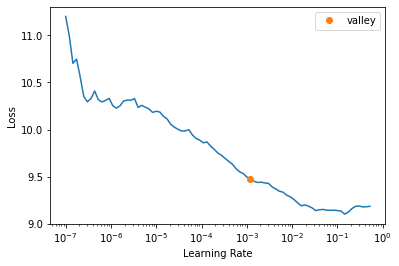

In [25]:
learn_yolox.lr_find()#

In [26]:
learn_yolox.fine_tune(100, 1e-03, freeze_epochs=1) #

Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'Dataset' object has no attribute 'items'


Better model found at epoch 0 with valid_loss value: 8.026368141174316.
Could not gather input dimensions


Better model found at epoch 0 with valid_loss value: 6.31726598739624.
Better model found at epoch 1 with valid_loss value: 6.181547164916992.
Better model found at epoch 2 with valid_loss value: 5.972879886627197.
Better model found at epoch 3 with valid_loss value: 5.274020671844482.
Better model found at epoch 4 with valid_loss value: 5.172465801239014.
Better model found at epoch 6 with valid_loss value: 4.835346221923828.
Better model found at epoch 8 with valid_loss value: 4.766491889953613.
Better model found at epoch 9 with valid_loss value: 4.728633403778076.
Better model found at epoch 16 with valid_loss value: 4.701524257659912.
Better model found at epoch 27 with valid_loss value: 4.393378734588623.
Better model found at epoch 40 with valid_loss value: 4.2969489097595215.
Better model found at epoch 41 with valid_loss value: 4.155333995819092.
Better model found at epoch 44 with valid_loss value: 4.040384292602539.
Better model found at epoch 51 with valid_loss value: 4.031

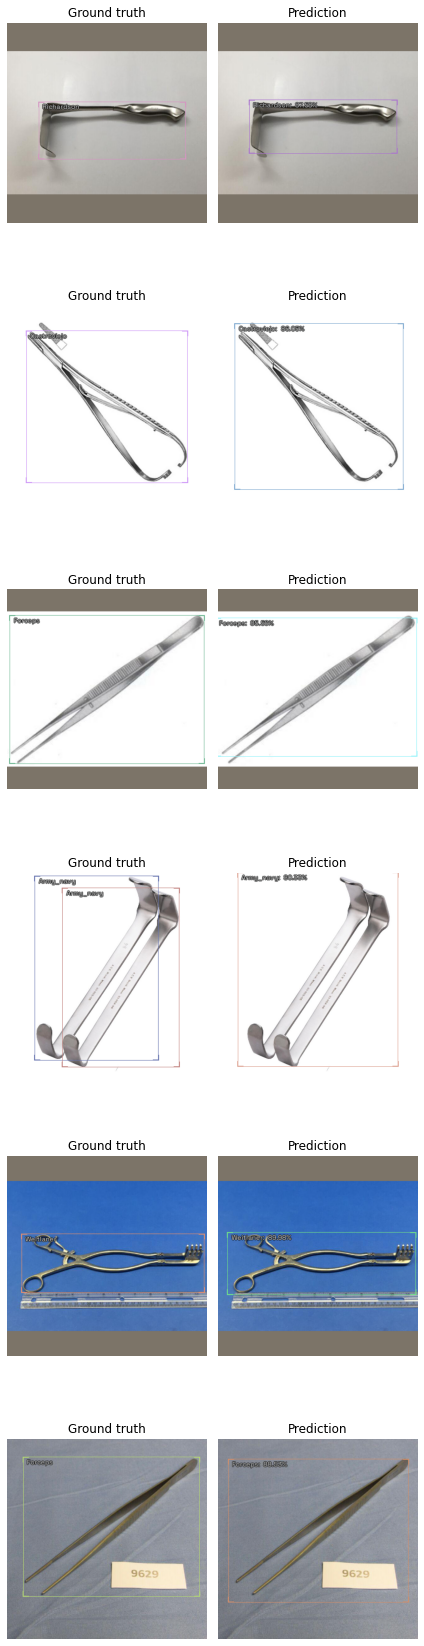

In [27]:
model_type_yolox.show_results(model_yolox,##
                              valid_ds)

In [28]:
root_dir = Path('/content/gdrive/My Drive/')

from icevision.models import *

checkpoint_path = root_dir/'Surgical_instruments/Models/YOLOX_nov14_mAP64.2.pth' #100 epochs, vf

save_icevision_checkpoint(model_yolox,## 
                        model_name='mmdet.yolox', ## 
                        backbone_name='yolox_tiny_8x8 ', ##
                        classes =  train_parser.class_map.get_classes(), 
                        img_size=image_size, 
                        filename=str(checkpoint_path), 
                        meta={'icevision_version': '0.9.1'})

Inference

  0%|          | 0/19 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/19 [00:00<?, ?it/s]

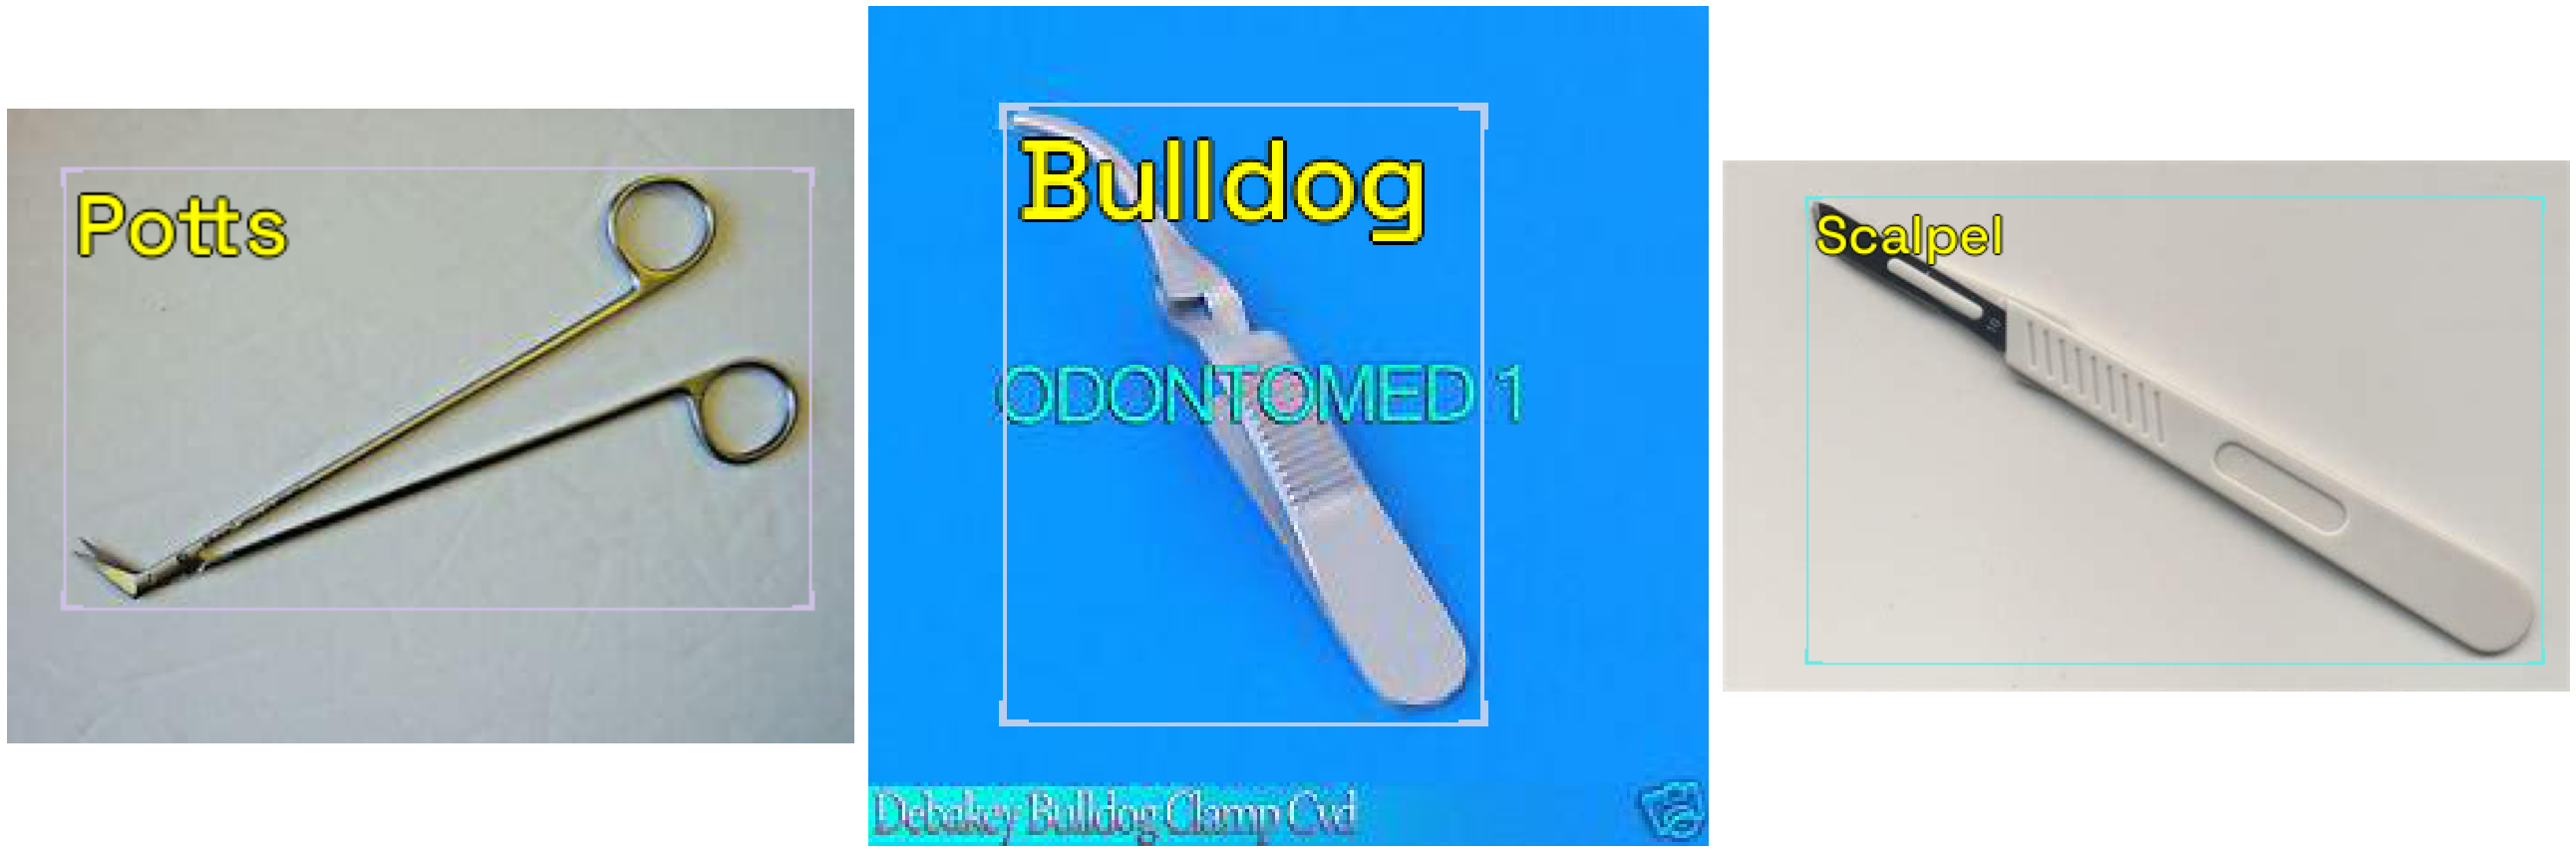

In [33]:
#path = Path('Surgical_instruments/Sets/Set_S/subsets/Set_1_7') # adjust if use git clone vs gdrive
path = Path('gdrive/MyDrive/Surgical_instruments/Second_set.v1i.coco')

test_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'test/_annotations.coco.json',
    img_dir = path/'test')

whole = SingleSplitSplitter()

test_records, *_ = test_parser.parse(data_splitter = whole)

show_records(test_records[0:3],ncols=3, font_size=30, label_color = '#ffff00')

In [34]:
#img_size = checkpoint_and_model["img_size"]

valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

#infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map = class_map)
infer_ds = Dataset(test_records, valid_tfms)#, class_map = class_map)

In [ ]:
#from icevision.models.checkpoint import *

#checkpoint_path = root_dir/'Surgical_instruments/Models/VFNet_nov13_mAP81.5.pth' #100 epochs, vf

#checkpoint_and_model = model_from_checkpoint(checkpoint_path)

#model_loaded = checkpoint_and_model["model"]

In [35]:
# Using trained vfnet resnet50_fpn_1x model
model_type = models.mmdet.vfnet ##
backbone = model_type.backbones.resnet50_fpn_1x##

In [ ]:
infer_dl = model_type.infer_dl(infer_ds, ##
                               batch_size=4, shuffle=False)

preds_saved_test = model_type.predict_from_dl(model_vf_1x,## 
                                              infer_dl,##
                                          keep_images=True, 
                                         detection_threshold = 0.5) ##

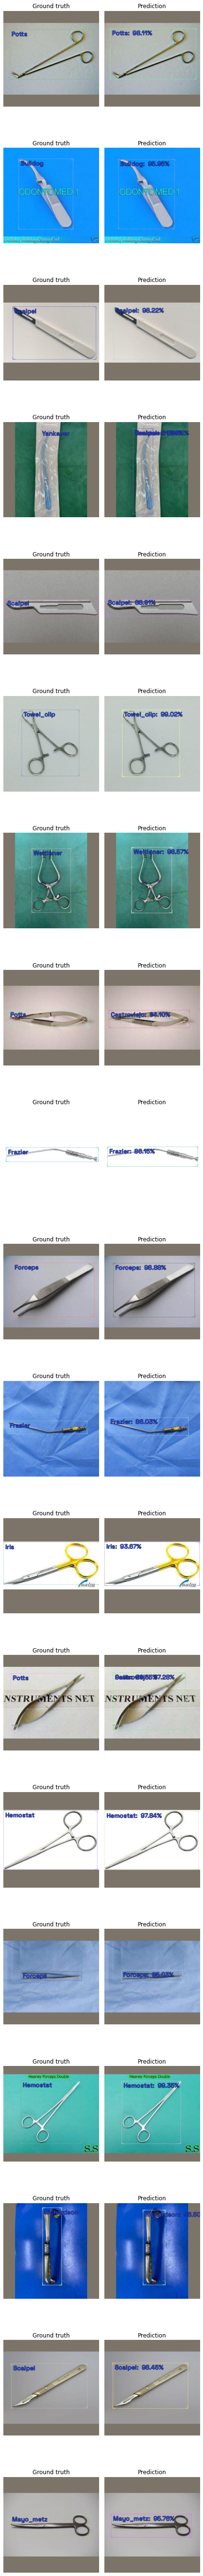

In [37]:
show_preds(preds=preds_saved_test[0:], font_size=25,
                        label_color = '#3050ff', )# blue)

Gradio Deployment of Trained model

In [ ]:
!echo "- Installing gradio"
!pip install gradio -U -q

In [39]:
import icedata
import PIL, requests
import torch
from torchvision import transforms
import gradio as gr

In [40]:
def show_preds_gradio(input_image, display_label, display_bbox, detection_threshold):

    if detection_threshold==0: detection_threshold=0.5

    img = PIL.Image.fromarray(input_image, 'RGB')

    pred_dict  = model_type.end2end_detect(img, ##
                                           valid_tfms, 
                                           model_vf_1x, ## 
                                           class_map=class_map, 
                                           detection_threshold=detection_threshold,
                                           display_label=display_label, 
                                           display_bbox=display_bbox, 
                                           return_img=True, 
                                           font_size=16, 
                                           label_color="#FF59D6")

    return pred_dict['img']

In [41]:
display_chkbox_label = gr.inputs.Checkbox(label="Label", default=True)
display_chkbox_box = gr.inputs.Checkbox(label="Box", default=True)

detection_threshold_slider = gr.inputs.Slider(minimum=0, maximum=1, step=0.1, 
                                              default=0.5, label="Detection Threshold")

outputs = gr.outputs.Image(type="pil")

gr_interface = gr.Interface(fn=show_preds_gradio, 
                            inputs=["image", display_chkbox_label, display_chkbox_box, detection_threshold_slider], 
                            outputs=outputs, 
                            title='Surgical Instruments Detection and Identification Tool')

In [42]:
gr_interface.launch(inline=False, share=True, debug=True)
# good predictions 

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://53150.gradio.app

This share link will expire in 72 hours. To get longer links, send an email to: support@gradio.app


KeyboardInterrupt: ignored